# This notebooks analyzes contributors giving to multiple candidates

In [369]:
from preprocessing import load_dataset, redownload_data, load_polls
import pandas as pd
import math
from networkx.drawing.nx_agraph import write_dot
from graphviz import Source
import sys
from graphviz import Digraph
import matplotlib.pyplot as plt
import datetime as dt

In [21]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [14]:
df = load_dataset()

C:\Users\Felix\Documents\MIT\Fall 19\6.439\Project\election-finance\preprocessing.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['party'] = np.where(df['cand_nm'].isin(republicans), 'Republican', 'Democratic')
C:\Users\Felix\Documents\MIT\Fall 19\6.439\Project\election-finance\preprocessing.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['in_50_states'] = np.where(df['contbr_st'].isin(us_states), 1, 0)
C:\Users\Felix\Documents\MIT\Fall 19\6.439\Project\election-finance\preprocessing.py:115: SettingWithCopyWarning: 
A valu

### Step 1) Find out contributors who gave to more than 1 candidate

In [15]:
print(" There are {} contributors".format(df['contbr_id'].nunique()))

 There are 553557 contributors


In [16]:
gp_contr_ct = df.groupby('contbr_id')['cand_nm'].nunique()
multiple_contributors = list(gp_contr_ct[gp_contr_ct > 1].index)
print("There are {} contributors with multiple candidates".format(len(multiple_contributors)))

There are 16333 contributors with multiple candidates


In [17]:
df_filtered = df[df['contbr_id'].isin(multiple_contributors)]

### Step 2) Get the top candidate for each month/contr_id

In [18]:
df_cand_gp = df_filtered.groupby(['contbr_id','month','cand_nm'])['contb_receipt_amt'].sum().reset_index()
df_cand_max = df_cand_gp.groupby(['contbr_id', 'month'])['contb_receipt_amt'].max().reset_index()
df_cand_nm = pd.merge(df_cand_gp, df_cand_max, 'inner', on=['contbr_id', 'month', 'contb_receipt_amt'])

# Remove duplicates (e.g. in case of tie)
df_top_cands = df_cand_nm.drop_duplicates(['contbr_id', 'month'])[['contbr_id', 'month', 'cand_nm']].rename({"cand_nm":"top_cand_nm"}, axis=1)

df_top_cands['last_top_cand_nm'] = df_top_cands.groupby(['contbr_id'])['top_cand_nm'].shift(1)

### Step 3) Get last month's top candidate in

In [19]:
df_cand_gp = pd.merge(df_cand_gp, df_top_cands, 'left',  on=['contbr_id', 'month'])

### Step 4) Create the network

In [332]:
import networkx as nx 
# 1) All links
nodes = df_cand_gp['cand_nm'].unique()
nodes = ['Biden, Joseph R Jr', 'Sanders, Bernard', 'Warren, Elizabeth ','Buttigieg, Pete', 'Harris, Kamala D.'] # Just show these candidates

months = sorted(df_cand_gp[df_cand_gp['month'] >= '2019-04-01']['month'].unique())

# Only keep this month and rows where the candidate is not last month's main candidate
graphs = []
for month in months:
    G=nx.DiGraph()

    # Add contributors
    G.add_nodes_from(nodes)
    df_filtered_date = df_cand_gp.loc[lambda f: f['month']==month].loc[lambda f: f['cand_nm']!=f['last_top_cand_nm']]
    
    if df_filtered_date['contb_receipt_amt'].sum() < 10000:
        continue

    for index, row in df_filtered_date.iterrows():
        cand_nm = row['cand_nm']
        last_cand_nm = row['last_top_cand_nm']
        amount = row['contb_receipt_amt']

        if cand_nm not in nodes or last_cand_nm not in nodes:
            continue
        if G.has_edge(last_cand_nm, cand_nm):
            G[last_cand_nm][cand_nm]['weight'] += amount
            G[last_cand_nm][cand_nm]['label'] += round(amount,0)

        else:
            G.add_edge(last_cand_nm, cand_nm, weight=amount,label=int(round(amount,0)))

    for a,b in G.edges:
        G[a][b]['label'] = str(int(round(max(0, int(G[a][b]['label'])) / 1000, 0))) + 'k'

    new_G = nx.drawing.nx_pydot.to_pydot(G)
    src = Source(new_G.to_string(), filename='data/' + str(month)[:10]) # dot is string containing DOT notation of graph
    #src.view()
    graphs.append(G)

In [333]:
def get_degrees(G):
    degrees = {node:0 for node in G.nodes}
    for node in G.nodes:
        for u, v, weight in G.edges(data='weight'):
            if v == node:
                degrees[node] += weight
            if u == node:
                degrees[node] -= weight
    return degrees  

In [334]:
# Create a time series of the degrees of each candidate
time_degrees_df = pd.DataFrame(columns = ['month'] + nodes)
for i in range(len(graphs)):
    graph = graphs[i]
    month = months[i]
    degrees = get_degrees(graph)
    degrees['month'] = (month)
    time_degrees_df = time_degrees_df.append(degrees, ignore_index=True)

In [335]:
time_degrees_df

,month,"Biden, Joseph R Jr","Sanders, Bernard","Warren, Elizabeth","Buttigieg, Pete","Harris, Kamala D."
0,2019-04-01,134514.40,-30123.16,54091.87,-20.96,-158462.15
1,2019-05-01,12951.03,-20883.92,43910.34,-16880.99,-19096.46
2,2019-06-01,-46302.58,-39077.86,159926.83,-88674.16,14127.77
3,2019-07-01,3846.68,-31931.08,48914.51,-89892.37,69062.26
4,2019-08-01,62448.44,-11773.51,87823.17,-59456.91,-79041.19
5,2019-09-01,97036.79,-25750.83,136660.10,-69832.41,-138113.65


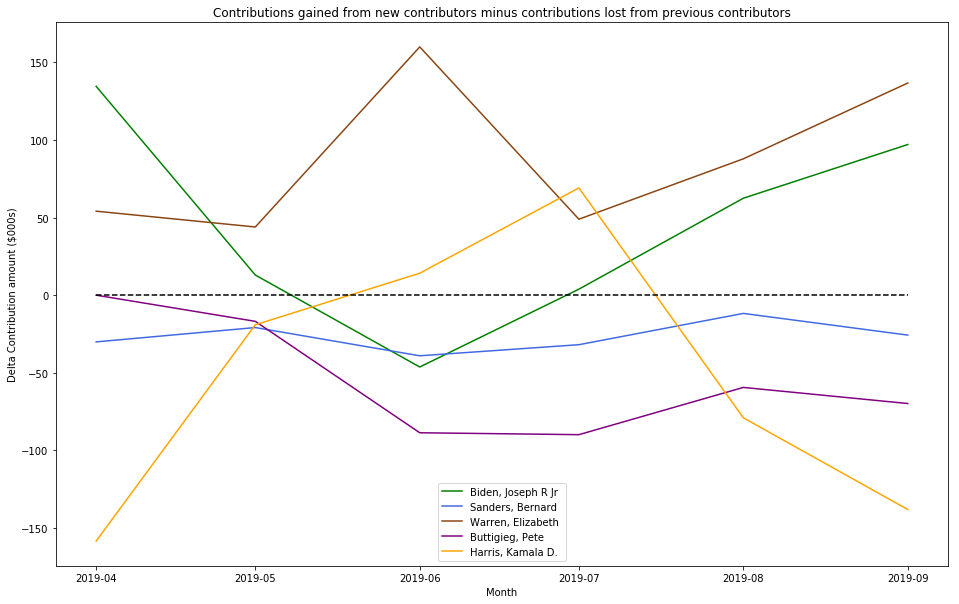

In [336]:
plt.figure(figsize=(16,10))
plt.title('Contributions gained from new contributors minus contributions lost from previous contributors')
color_dict = {'Biden, Joseph R Jr':'green',
              'Sanders, Bernard':'royalblue',
              'Warren, Elizabeth ':'saddlebrown',
              'Buttigieg, Pete':'purple',
              'Harris, Kamala D.':'orange'} # Just show these candidates

for node in nodes:
    color = ''
    if node in color_dict:
        color = color_dict[node]
    plt.plot(time_degrees_df['month'], time_degrees_df[node]/1000, label=node, color=color)
plt.plot(time_degrees_df['month'], time_degrees_df[node]*0, linestyle='--', color='black', label='')
plt.legend()
plt.xlabel('Month')
plt.ylabel('Delta Contribution amount ($000s)')
plt.show()

In [299]:
# We can now retrieve the closest candidate for each candidate

def get_closest_candidate(G):
    contributions = []
    new_G = nx.DiGraph()
    for node in graphs[0].nodes:
        degrees = {node:0 for node in G.nodes}
        max_u = 0
        u_cand = ''
        max_v = 0
        v_cand = ''
        
        for u, v, weight in G.edges(data='weight'):
           # if v == node:
           #      if weight > max_v:
           #             v_cand = v
           #             max_v = weight
            if u == node:
                 if weight > max_u:
                        u_cand = v
                        max_u = weight
        if max_u > 10000:
            
            new_G.add_node(node)
            new_G.add_edge(node, u_cand, weight=max_u)#,label=int(round(max_u,0)))
    return new_G  

In [300]:
def combine_graphs(graphs):
    new_G = nx.DiGraph()
    edges = {}
    for G in graphs:
        for u, v, weight in G.edges(data='weight'):
            if (u,v) in edges:
                edges[(u,v)] += weight
            else:
                edges[(u,v)] = weight
    for key,val in edges.items():
        new_G.add_edge(key[0], key[1], weight=val)#,label=int(round(max_u,0)))
    return new_G


In [301]:
combined_G = combine_graphs([graphs[-1]])
closest_G = get_closest_candidate(combined_G)

In [302]:
for u, v, weight in combined_G.edges(data='weight'):
    print(u, v, weight)

Biden, Joseph R Jr Klobuchar, Amy J. 63208.2
Biden, Joseph R Jr Harris, Kamala D. 35012.3
Biden, Joseph R Jr O’Rourke, Robert Beto 10359.300000000001
Biden, Joseph R Jr Castro, Julián 2705.0
Biden, Joseph R Jr Hickenlooper, John W. -2948.75
Biden, Joseph R Jr Buttigieg, Pete 31618.489999999998
Biden, Joseph R Jr Bennet, Michael F. 11815.0
Biden, Joseph R Jr Williamson, Marianne  150.0
Biden, Joseph R Jr Sanders, Bernard 2084.76
Biden, Joseph R Jr Gabbard, Tulsi 450.0
Biden, Joseph R Jr Warren, Elizabeth  20753.16
Biden, Joseph R Jr Yang, Andrew 2001.4099999999999
Biden, Joseph R Jr Booker, Cory A. 66086.2
Biden, Joseph R Jr Bullock, Steve 8560.0
Biden, Joseph R Jr Delaney, John K. 610.0
Biden, Joseph R Jr Weld, William Floyd (Bill) 500.0
Biden, Joseph R Jr Ryan, Timothy J. 35.0
Biden, Joseph R Jr de Blasio, Bill 2800.0
Biden, Joseph R Jr Sestak, Joseph A. Jr. 500.0
Biden, Joseph R Jr Steyer, Tom 50.0
Klobuchar, Amy J. Buttigieg, Pete 29002.03
Klobuchar, Amy J. Warren, Elizabeth  13068.

In [303]:
closest_G.nodes

NodeView(('Biden, Joseph R Jr', 'Booker, Cory A.', 'Bullock, Steve', 'Klobuchar, Amy J.', 'Buttigieg, Pete', 'Yang, Andrew', 'Harris, Kamala D.', 'Hickenlooper, John W.', 'Bennet, Michael F.', 'Warren, Elizabeth ', 'Sanders, Bernard', 'Gillibrand, Kirsten ', 'Castro, Julián', 'O’Rourke, Robert Beto', 'Inslee, Jay R', 'Delaney, John K.', 'de Blasio, Bill', 'Gabbard, Tulsi'))

In [305]:
new_closest_G = nx.drawing.nx_pydot.to_pydot(closest_G)
src = Source(new_closest_G.to_string(), filename='data/closest_graph') # dot is string containing DOT notation of graph
src.view()

'data\\closest_graph.pdf'

In [306]:
nx.pagerank(combined_G, alpha=0.9)

{'Biden, Joseph R Jr': 0.16953662701616976,
 'Klobuchar, Amy J.': 0.08218214493746649,
 'Harris, Kamala D.': 0.103862063541963,
 'O’Rourke, Robert Beto': 0.046053230637506444,
 'Castro, Julián': 0.01635235738745974,
 'Hickenlooper, John W.': -0.005949326074541692,
 'Buttigieg, Pete': 0.13184898349148094,
 'Bennet, Michael F.': 0.029351470194622847,
 'Williamson, Marianne ': 0.005159643932170605,
 'Sanders, Bernard': 0.03756006877397029,
 'Gabbard, Tulsi': 0.0124089832476276,
 'Warren, Elizabeth ': 0.12799409096634806,
 'Yang, Andrew': 0.02240691614944176,
 'Booker, Cory A.': 0.10317720563373334,
 'Bullock, Steve': 0.020371335538811316,
 'Delaney, John K.': 0.006666101445335195,
 'Weld, William Floyd (Bill)': 0.013593668878956636,
 'Ryan, Timothy J.': 0.005654254420207013,
 'de Blasio, Bill': 0.006873952530084927,
 'Sestak, Joseph A. Jr.': 0.005567550712668135,
 'Steyer, Tom': 0.016554101116579185,
 'Gillibrand, Kirsten ': 0.00415687323684794,
 'Inslee, Jay R': 0.00415687323684794,
 'Mo

{('Biden, Joseph R Jr',
  'Harris, Kamala D.'): Text(0.307641,-0.98892,'35012.3'),
 ('Sanders, Bernard',
  'Warren, Elizabeth '): Text(-0.22932,0.670537,'57390.72'),
 ('Warren, Elizabeth ',
  'Sanders, Bernard'): Text(-0.221342,0.668818,'37782.23000000002'),
 ('Buttigieg, Pete',
  'Warren, Elizabeth '): Text(-0.212819,0.663723,'84345.39'),
 ('Harris, Kamala D.',
  'Biden, Joseph R Jr'): Text(0.303377,-0.995251,'91202.5')}

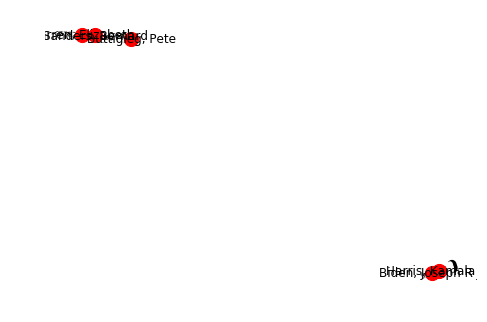

In [214]:
weights = [round(closest_G[u][v]['weight']/10000, 1) for u,v in closest_G.edges]
pos = nx.spring_layout(closest_G)
nx.draw(closest_G, edges=closest_G.edges, width=weights, pos=pos, node_size=200, with_labels = True)
edge_labels=dict([((u,v,),d['weight'])
             for u,v,d in closest_G.edges(data=True)])
nx.draw_networkx_edge_labels(closest_G, pos, edge_labels=edge_labels, label_pos=0.3, font_size=7)

{('Sanders, Bernard',
  'Warren, Elizabeth '): Text(-0.0146376,-0.19061,'24605.85'),
 ('Sanders, Bernard', 'Buttigieg, Pete'): Text(-0.037729,-0.491186,'9514.51'),
 ('Sanders, Bernard', 'Biden, Joseph R Jr'): Text(0.0495684,0.645388,'2832.0'),
 ('Warren, Elizabeth ',
  'Buttigieg, Pete'): Text(-0.0380063,-0.49486,'18492.9'),
 ('Warren, Elizabeth ',
  'Sanders, Bernard'): Text(-0.0142679,-0.185712,'5059.2'),
 ('Warren, Elizabeth ',
  'Biden, Joseph R Jr'): Text(0.0492911,0.641715,'6600.0'),
 ('Buttigieg, Pete',
  'Warren, Elizabeth '): Text(-0.0248112,-0.323102,'38468.12'),
 ('Buttigieg, Pete', 'Biden, Joseph R Jr'): Text(0.0393948,0.512897,'43547.4'),
 ('Buttigieg, Pete', 'Sanders, Bernard'): Text(-0.0241642,-0.314531,'627.0')}

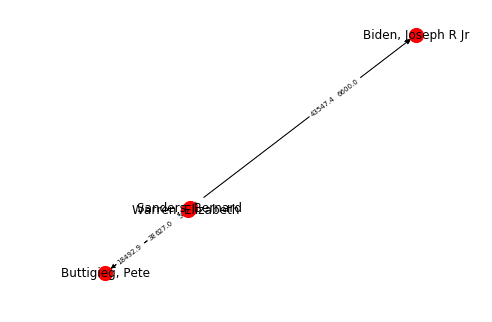

In [67]:
G= graphs[0]
max_contr = max(G[u][v]['weight'] for u,v in G.edges)
weights = [round(G[u][v]['weight']/max_contr, 1) for u,v in G.edges]
pos = nx.spring_layout(G)
nx.draw(G, edges=G.edges, width=weights, pos=pos, node_size=200, with_labels = True)
edge_labels=dict([((u,v,),d['weight'])
             for u,v,d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3, font_size=7)

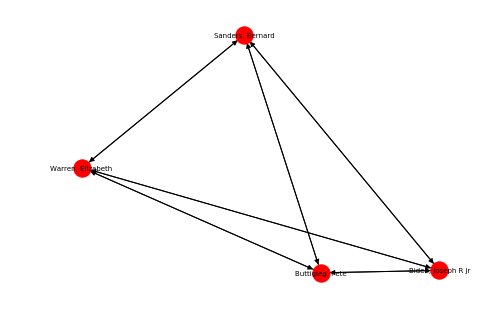

In [102]:
nx.draw(G, with_labels=True, edge_labels=edge_labels, label_pos=0.3, font_size=7)

In [64]:
G

In [307]:
print(a)

Walsh, Joe


In [308]:
import requests
# API call to retrieve report
url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-historical-data"
querystrings = {"frequency":"1mo","filter":"history","period1":"1546448400","period2":"1562086800","symbol":"AMZN",}
headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': "0bfbce4dc4mshf64752f5cd08067p1b69aajsn983d0ee17fe8"
    }
response = requests.request("GET", url, headers=headers, params=querystrings)

In [312]:
response.text

'{"prices":[{"date":1561953600,"open":1922.97998046875,"high":2035.800048828125,"low":1849.43994140625,"close":1866.780029296875,"volume":73148800,"adjclose":1866.780029296875},{"date":1559361600,"open":1760.010009765625,"high":1935.199951171875,"low":1672,"close":1893.6300048828125,"volume":74746500,"adjclose":1893.6300048828125},{"date":1556683200,"open":1933.0899658203125,"high":1964.4000244140625,"low":1772.699951171875,"close":1775.0699462890625,"volume":98214400,"adjclose":1775.0699462890625},{"date":1554091200,"open":1800.1099853515625,"high":1956.3399658203125,"low":1798.72998046875,"close":1926.52001953125,"volume":81239200,"adjclose":1926.52001953125},{"date":1551416400,"open":1655.1300048828125,"high":1823.75,"low":1586.5699462890625,"close":1780.75,"volume":100832200,"adjclose":1780.75},{"date":1548997200,"open":1638.8800048828125,"high":1673.06005859375,"low":1566.760009765625,"close":1639.8299560546875,"volume":80936900,"adjclose":1639.8299560546875},{"date":1546318800,"o

{'prices': [{'date': 1561953600,
   'open': 1922.97998046875,
   'high': 2035.800048828125,
   'low': 1849.43994140625,
   'close': 1866.780029296875,
   'volume': 73148800,
   'adjclose': 1866.780029296875},
  {'date': 1559361600,
   'open': 1760.010009765625,
   'high': 1935.199951171875,
   'low': 1672,
   'close': 1893.6300048828125,
   'volume': 74746500,
   'adjclose': 1893.6300048828125},
  {'date': 1556683200,
   'open': 1933.0899658203125,
   'high': 1964.4000244140625,
   'low': 1772.699951171875,
   'close': 1775.0699462890625,
   'volume': 98214400,
   'adjclose': 1775.0699462890625},
  {'date': 1554091200,
   'open': 1800.1099853515625,
   'high': 1956.3399658203125,
   'low': 1798.72998046875,
   'close': 1926.52001953125,
   'volume': 81239200,
   'adjclose': 1926.52001953125},
  {'date': 1551416400,
   'open': 1655.1300048828125,
   'high': 1823.75,
   'low': 1586.5699462890625,
   'close': 1780.75,
   'volume': 100832200,
   'adjclose': 1780.75},
  {'date': 1548997200,

In [320]:
import pandas as pd
pd.DataFrame.from_dict(response.json()['prices'])

,adjclose,close,date,high,low,open,volume
0,1866.780029,1866.780029,1561953600,2035.800049,1849.439941,1922.979980,73148800
1,1893.630005,1893.630005,1559361600,1935.199951,1672.000000,1760.010010,74746500
2,1775.069946,1775.069946,1556683200,1964.400024,1772.699951,1933.089966,98214400
3,1926.520020,1926.520020,1554091200,1956.339966,1798.729980,1800.109985,81239200
4,1780.750000,1780.750000,1551416400,1823.750000,1586.569946,1655.130005,100832200
5,1639.829956,1639.829956,1548997200,1673.060059,1566.760010,1638.880005,80936900
6,1718.729980,1718.729980,1546318800,1736.410034,1460.930054,1465.199951,134001700


In [339]:
polls = load_polls()

In [360]:
polls['fte_grade'] = polls['fte_grade'].fillna('')

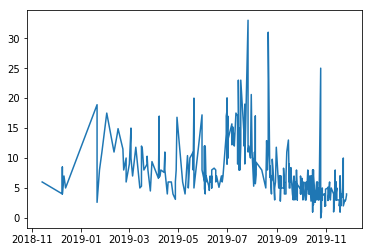

In [362]:
poll_results = polls[polls['candidate_name'] == 'Kamala D. Harris'].loc[lambda f: ~f['fte_grade'].str.contains('C')].sort_values('end_date')
plt.plot(poll_results['end_date'], poll_results['pct'])

In [353]:
poll_results = polls[polls['candidate_name'] == 'Kamala D. Harris'].loc[lambda f: ~f['fte_grade'].str.contains('C')].sort_values('end_date')
plt.plot(poll_results['end_date'], poll_results['pct'])

,poll_id,start_date,end_date,party,candidate_name,pct,created_at,state,pollster,sponsors,pollster_rating_name,fte_grade,sample_size
1843,62439,2019-10-07,2019-10-16,DEM,Kamala D. Harris,0.00,2019-10-23 17:43:00,Wyoming,Montana State University Billings,NaN,Montana State University Billings,B/C,14
1313,62550,2019-10-13,2019-10-25,DEM,Kamala D. Harris,0.00,2019-11-08 07:59:00,Michigan,Siena College/New York Times Upshot,NaN,Siena College/New York Times Upshot,A+,203
1325,62552,2019-10-13,2019-10-25,DEM,Kamala D. Harris,1.00,2019-11-08 07:59:00,Pennsylvania,Siena College/New York Times Upshot,NaN,Siena College/New York Times Upshot,A+,304
1926,62579,2019-09-23,2019-10-15,DEM,Kamala D. Harris,1.00,2019-11-07 07:50:00,Minnesota,Kaiser Family Foundation,Cook Political Report,Kaiser Family Foundation,NaN,249
1252,62549,2019-10-13,2019-10-26,DEM,Kamala D. Harris,1.00,2019-11-08 07:59:00,Florida,Siena College/New York Times Upshot,NaN,Siena College/New York Times Upshot,A+,236
642,62596,2019-11-06,2019-11-10,DEM,Kamala D. Harris,1.00,2019-11-11 15:02:00,New Hampshire,Quinnipiac University,NaN,Quinnipiac University,B+,1134
1276,62553,2019-10-13,2019-10-26,DEM,Kamala D. Harris,1.00,2019-11-08 08:00:00,Wisconsin,Siena College/New York Times Upshot,NaN,Siena College/New York Times Upshot,A+,292
1264,62551,2019-10-13,2019-10-26,DEM,Kamala D. Harris,1.00,2019-11-08 07:59:00,North Carolina,Siena College/New York Times Upshot,NaN,Siena College/New York Times Upshot,A+,324
291,62666,2019-11-13,2019-11-18,DEM,Kamala D. Harris,1.00,2019-11-19 17:41:00,New Hampshire,St. Anselm,NaN,St. Anselm,NaN,255
2513,59897,2019-09-30,2019-10-06,DEM,Kamala D. Harris,1.00,2019-10-08 09:02:00,Pennsylvania,Susquehanna Polling & Research Inc.,WPMT-TV,Susquehanna Polling & Research Inc.,C,307


In [371]:
kamala_harris_polls = [9
,8.5
,7.2
,7.7
,7.5
,6.6
,10
,13.6
,11.0
,8
,7.2
,6.4]

kamala_harris_dates = ['2019-04-01', '2019-04-15', '2019-05-01','2019-05-15', '2019-06-01', '2019-06-15', '2019-07-01', '2019-07-15',
                      '2019-08-01', '2019-08-15', '2019-09-01', '2019-09-15']
kamala_harris_dates = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in kamala_harris_dates]

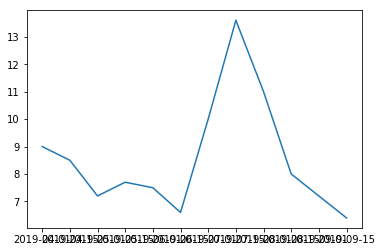

In [364]:
plt.plot(kamala_harris_dates, kamala_harris_polls)

No handles with labels found to put in legend.


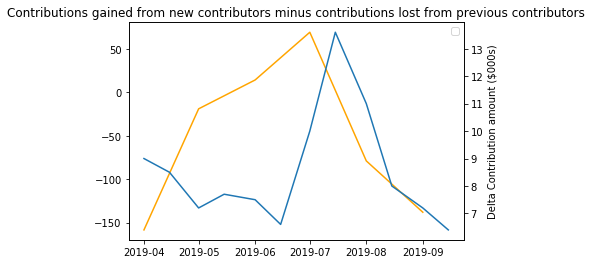

In [374]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
plt.title('Contributions gained from new contributors minus contributions lost from previous contributors')
color_dict = {'Biden, Joseph R Jr':'green',
              'Sanders, Bernard':'royalblue',
              'Warren, Elizabeth ':'saddlebrown',
              'Buttigieg, Pete':'purple',
              'Harris, Kamala D.':'orange'} # Just show these candidates

node = 'Harris, Kamala D.'
ax1.plot(time_degrees_df['month'], time_degrees_df[node]/1000, label=node, color=color)
#ax1.plot(time_degrees_df['month'], time_degrees_df[node]*0, linestyle='--', color='black', label='')
ax2.plot(kamala_harris_dates, kamala_harris_polls)
plt.legend()
plt.xlabel('Month')
plt.ylabel('Delta Contribution amount ($000s)')
plt.show()